In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import *
import astropy
from astropy import constants as ac
from astroquery.mast import Observations
import lightkurve
import celerite
from celerite import terms
from scipy.optimize import minimize
from astropy.io import fits
from astropy.table import Table

Testing out the examples from the celerite documentation: https://celerite.readthedocs.io/en/stable/tutorials/first/

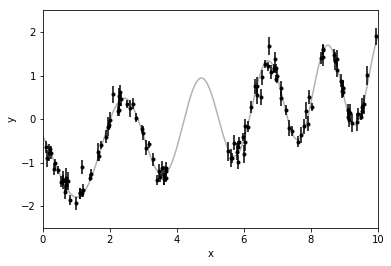

In [2]:
np.random.seed(42)

t = np.sort(np.append(
    np.random.uniform(0, 3.8, 57),
    np.random.uniform(5.5, 10, 68),
))  # The input coordinates must be sorted
yerr = np.random.uniform(0.08, 0.22, len(t))
y = 0.2 * (t-5) + np.sin(3*t + 0.1*(t-5)**2) + yerr * np.random.randn(len(t))

true_t = np.linspace(0, 10, 5000)
true_y = 0.2 * (true_t-5) + np.sin(3*true_t + 0.1*(true_t-5)**2)

plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(0, 10)
plt.ylim(-2.5, 2.5);

In [3]:
# A non-periodic component
Q = 1.0 / np.sqrt(2.0)
w0 = 3.0
S0 = np.var(y) / (w0 * Q)
bounds = dict(log_S0=(-15, 15), log_Q=(-15, 15), log_omega0=(-15, 15))
kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                       bounds=bounds)
kernel.freeze_parameter("log_Q")  # We don't want to fit for "Q" in this term

# A periodic component
Q = 1.0
w0 = 3.0
S0 = np.var(y) / (w0 * Q)
kernel += terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                        bounds=bounds)

In [4]:
gp = celerite.GP(kernel, mean=np.mean(y))
gp.compute(t, yerr)  # You always need to call compute once.
print("Initial log likelihood: {0}".format(gp.log_likelihood(y)))

Initial log likelihood: -6.756596382629269


In [5]:
print("parameter_dict:\n{0}\n".format(gp.get_parameter_dict()))
print("parameter_names:\n{0}\n".format(gp.get_parameter_names()))
print("parameter_vector:\n{0}\n".format(gp.get_parameter_vector()))
print("parameter_bounds:\n{0}\n".format(gp.get_parameter_bounds()))

parameter_dict:
OrderedDict([('kernel:terms[0]:log_S0', -0.8497786656258695), ('kernel:terms[0]:log_omega0', 1.0986122886681098), ('kernel:terms[1]:log_S0', -1.1963522559058422), ('kernel:terms[1]:log_Q', 0.0), ('kernel:terms[1]:log_omega0', 1.0986122886681098)])

parameter_names:
('kernel:terms[0]:log_S0', 'kernel:terms[0]:log_omega0', 'kernel:terms[1]:log_S0', 'kernel:terms[1]:log_Q', 'kernel:terms[1]:log_omega0')

parameter_vector:
[-0.84977867  1.09861229 -1.19635226  0.          1.09861229]

parameter_bounds:
[(-15, 15), (-15, 15), (-15, 15), (-15, 15), (-15, 15)]



In [6]:
from scipy.optimize import minimize

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()

r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(y, gp))
gp.set_parameter_vector(r.x)
print(r)

      fun: -16.56320171269553
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.84217094e-06,  1.05160325e-04, -4.54747351e-05, -5.68434189e-06,
       -5.20117283e-04])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 252
      nit: 30
   status: 0
  success: True
        x: array([ 3.277941  , -2.02450473, -4.16135883,  2.34185049,  1.13554439])


In [7]:
gp.get_parameter_dict()

OrderedDict([('kernel:terms[0]:log_S0', 3.277941000956591),
             ('kernel:terms[0]:log_omega0', -2.024504730787932),
             ('kernel:terms[1]:log_S0', -4.161358828835926),
             ('kernel:terms[1]:log_Q', 2.3418504900107107),
             ('kernel:terms[1]:log_omega0', 1.1355443876655091)])

In [8]:
x = np.linspace(0, 10, 5000)
pred_mean, pred_var = gp.predict(y, x, return_var=True)
pred_std = np.sqrt(pred_var)

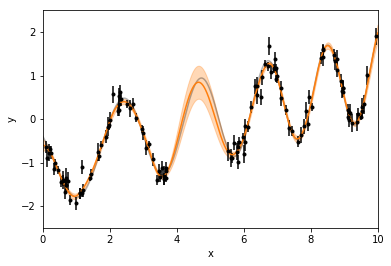

In [9]:
color = "#ff7f0e"
plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3,
                 edgecolor="none")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(0, 10)
plt.ylim(-2.5, 2.5);

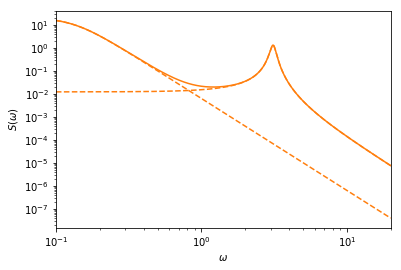

In [10]:
omega = np.exp(np.linspace(np.log(0.1), np.log(20), 5000))
psd = gp.kernel.get_psd(omega)

plt.plot(omega, psd, color=color)
for k in gp.kernel.terms:
    plt.plot(omega, k.get_psd(omega), "--", color=color)

plt.yscale("log")
plt.xscale("log")
plt.xlim(omega[0], omega[-1])
plt.xlabel("$\omega$")
plt.ylabel("$S(\omega)$");

### Now lets try this on data for GJ1243

First step is to mask out all of the flares in each month. Thanks to Jim's data table we know where the flares are to help mask them.

In [2]:
flare_table=pd.read_csv('https://raw.githubusercontent.com/jradavenport/GJ1243-Flares/master/data/gj1243_master_flares.tbl',
            skiprows=23,delim_whitespace=True,names=['index of flare start in "gj1243_master_slc.dat"',
                                                   'index of flare stop in "gj1243_master_slc.dat"','t_start','t_stop'
                                                   ,'t_peak','t_rise','t_decay','flux peak',
                                                   '(ED) in units of per seconds','Duration of rise',
                                                   'Duration of decay','Complex flag',
                                                   '# of people that identified flare event exists',
                                                   '# of people that analyzed this month',
                                                   '# of flare template components fit to event'])

In [218]:
#flare_table

In [3]:
t_starts=flare_table.loc[:,'t_start']
t_stops=flare_table.loc[:,'t_stop']
flux_peak = flare_table.loc[:,'flux peak']

In [4]:
t_starts[0],t_stops[0]


(539.5628662, 539.5778197999999)

Importing in the GJ1243 data from Kepler

In [5]:
from lightkurve import search_lightcurvefile
from lightkurve import search_targetpixelfile
target = '9726699'
gj1243_collection = search_lightcurvefile(target,cadence='short').download_all()
print (gj1243_collection)

LightCurveFileCollection of 11 objects:
KeplerLightCurveFile(ID: 9726699) 
KeplerLightCurveFile(ID: 9726699) 
KeplerLightCurveFile(ID: 9726699) 
KeplerLightCurveFile(ID: 9726699) 
KeplerLightCurveFile(ID: 9726699) 
KeplerLightCurveFile(ID: 9726699) 
KeplerLightCurveFile(ID: 9726699) 
KeplerLightCurveFile(ID: 9726699) 
KeplerLightCurveFile(ID: 9726699) 
KeplerLightCurveFile(ID: 9726699) 
KeplerLightCurveFile(ID: 9726699) 



In [6]:
gj1243lc = gj1243_collection[0].PDCSAP_FLUX

for q in range(1,len(gj1243_collection)):
    try:
        gj1243lc = gj1243lc.append(gj1243_collection[q].PDCSAP_FLUX)
    except:
            print(q)

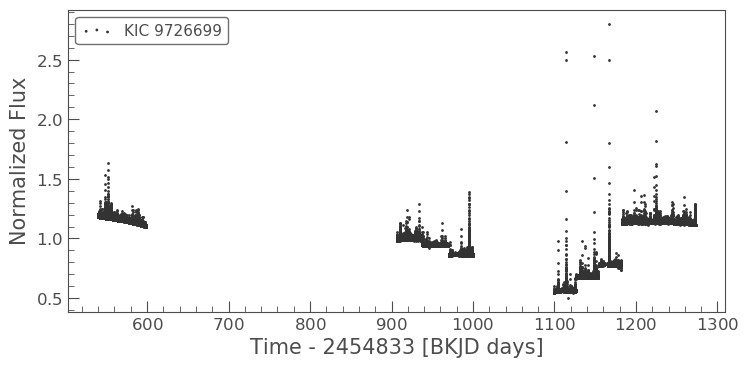

In [7]:
gj1243lc.scatter()

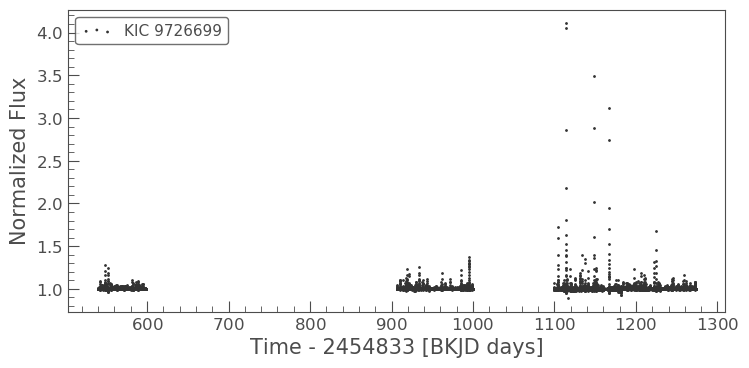

In [8]:
gj1243lc.flatten(window_length=11).scatter()

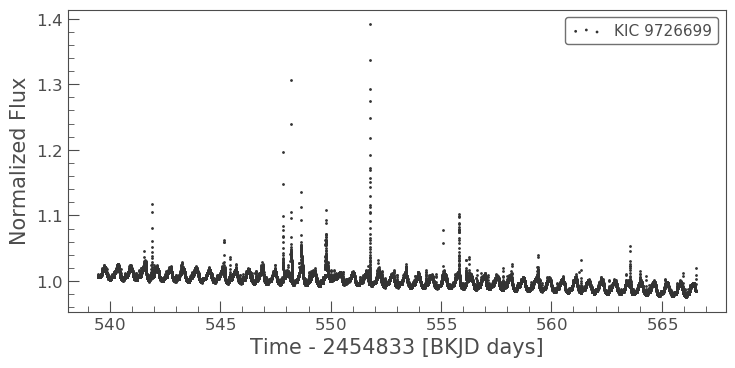

In [9]:
#plotting one month of data
gj1243_collection[0].PDCSAP_FLUX.scatter()

(1, 1.03)

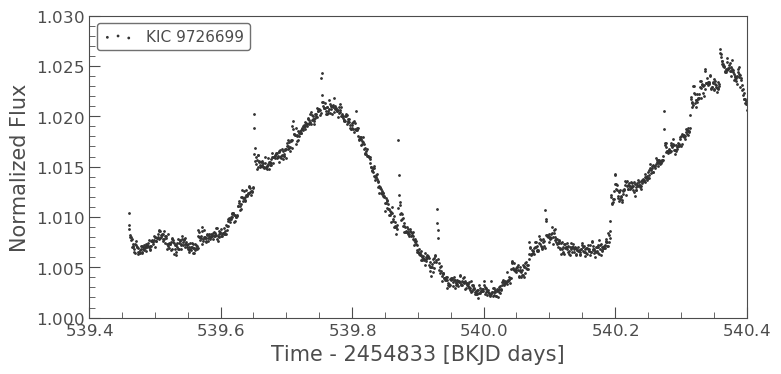

In [10]:
#plotting one day of first month
gj1243_collection[0].PDCSAP_FLUX.scatter()
plt.xlim(539.4,540.4)
plt.ylim(1,1.03)

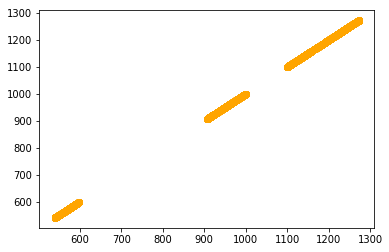

In [11]:
#gj1243_collection[0].PDCSAP_FLUX.scatter()
plt.plot(t_starts,t_stops, 'o', color='orange')
#plt.xlim(539.4,540)


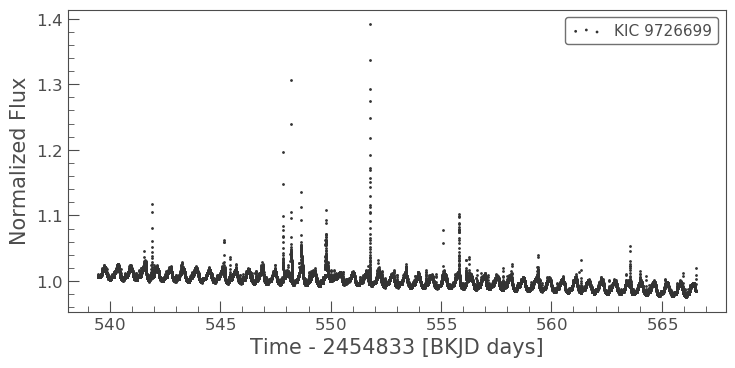

In [12]:
oneday=gj1243_collection[0].PDCSAP_FLUX.scatter()
oneday

In [13]:
flat_gj1243lc = gj1243lc.flatten(window_length=11)
#flat_gj1243lc.scatter()

In [14]:
#convert flattened, short cadence, lightkurve objects to fits file to extract fluxes & times
hdu = flat_gj1243lc.to_fits(path='gj1243_output.fits', overwrite=True)

In [15]:
from astropy.io import fits
hdu = fits.open('gj1243_output.fits')
hdu

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x1c1f8be5f8>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x1c1f89deb8>]

In [16]:
hdu[1].columns

ColDefs(
    name = 'TIME'; format = 'D'; unit = 'bkjd'
    name = 'FLUX'; format = 'E'; unit = 'counts'
    name = 'FLUX_ERR'; format = 'E'; unit = 'counts'
    name = 'CADENCENO'; format = 'J'
    name = 'SAP_QUALITY'; format = 'K'
)

In [17]:
kepler_time = hdu[1].data['TIME']
kepler_flux = hdu[1].data['FLUX']
kepler_flux_err = hdu[1].data['FLUX_ERR']
kepler_cadence = hdu[1].data['CADENCENO']
kepler_sap_qual = hdu[1].data['SAP_QUALITY']
median=np.nanmedian(kepler_flux)

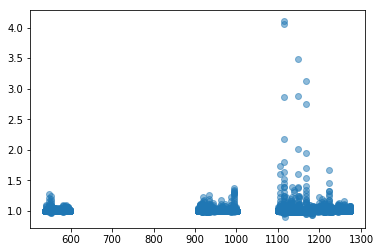

In [18]:
plt.scatter(kepler_time,kepler_flux/median,marker='o',alpha=0.5)

(0.99, 1.03)

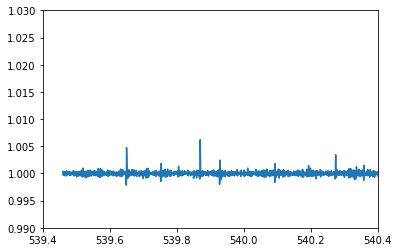

In [19]:
#one day of flares
plt.plot(kepler_time,kepler_flux/median)
plt.xlim(539.4,540.4)
plt.ylim(0.99,1.03)

(0.9, 1.1)

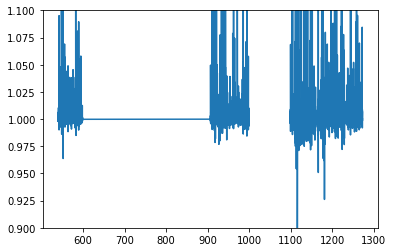

In [31]:
''''
The code below masks the start time of only one flare, the threshold can be any number 
Need to figure out how to correlate start and stop times to be one complete flare that I can mask
and match up with most recent detrended data 
''''

one_flare_start=t_starts[0]
one_flare_stop=t_stops[0]

#give a threshold
threshold = 100

one_flare_start = np.ma.array(one_flare_start)

one_flare_start_masked = np.ma.masked_where(one_flare_start > threshold , one_flare_start)
#x_values = [0,500,550,551]
plt.plot(kepler_time,kepler_flux/median)
#plt.plot(t_starts,t_stops)
#plt.plot(t_starts[0],1,'ko')
plt.plot(one_flare_start_masked,1,'ko')
plt.ylim(0.9,1.1)
#plt.xlim(539,540)

In [ ]:
np.ones(11)

In [ ]:
for flare in range(len(t_starts),len(t_stops)):
    lc = True if flare == 0 else False

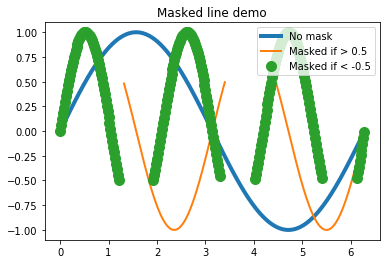

In [33]:
'''
Plot lines with points masked out.

This would typically be used with gappy data, to
break the line at the data gaps.

Could be used for flares already identified for GJ1243 but need to find a way to generalize it to any star
'''

import matplotlib.pyplot as plt
import numpy as np

x = np.arange(0, 2*np.pi, 0.02)
y = np.sin(x)
y1 = np.sin(2*x)
y2 = np.sin(3*x)
ym1 = np.ma.masked_where(y1 > 0.5, y1)
ym2 = np.ma.masked_where(y2 < -0.5, y2)

lines = plt.plot(x, y, x, ym1, x, ym2, 'o')
plt.setp(lines[0], linewidth=4)
plt.setp(lines[1], linewidth=2)
plt.setp(lines[2], markersize=10)

plt.legend(('No mask', 'Masked if > 0.5', 'Masked if < -0.5'),
           loc='upper right')
plt.title('Masked line demo')
plt.show()

ValueError: x and y must have same first dimension, but have shapes (453357,) and (6107,)

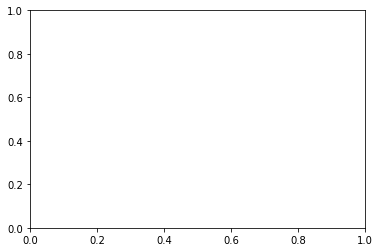

In [45]:
x = kepler_time
y= kepler_flux/median
y1 = t_starts
y2 = t_stops
ym1 = np.ma.masked_where(y1 > 0, y1)
ym2 = np.ma.masked_where(y2 > 0, y2)

lines = plt.plot(x,y,x, ym1, x, ym2, 'o')
plt.setp(lines[0], linewidth=4)
plt.setp(lines[1], linewidth=2)
plt.setp(lines[2], markersize=10)

plt.show()